### CS180 Project 1: Colorizing the Prokudin-Gorskii photo collection

In [27]:
# Instead of scikit-image you could use matplotlib and opencv to read, write, and display images
import numpy as np
import skimage as sk
import skimage.io as skio
import matplotlib.pyplot as plt

/tmp/ipython-input-2608767755.py:17: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(im)
/tmp/ipython-input-2608767755.py:18: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.show()


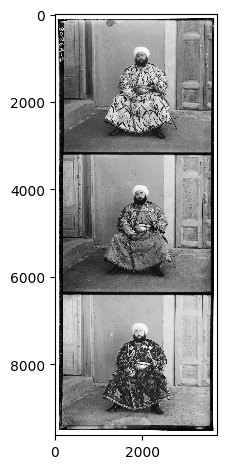

In [28]:
def loadImages(input_file=None):
  """Loads the image that want to align the color channels for.

  input (str): input file name
  output (numpy array): image array (float)
  """

  if input_file is None:
    raise ValueError("You must provide an input file")
  imname = input_file

  # read in the image
  im = skio.imread(imname)

  # convert to double (might want to do this later on to save memory)
  im = sk.img_as_float(im)
  skio.imshow(im)
  skio.show()

  return im

def seperateChannels(image):
  """Takes input from loadImages and separetes the color channels.
  The channels are organized as BGR.

  input (numpy array): image array (float) that was loaded
  output (numpy array): BGR channels
  """
  # compute the height of each part (just 1/3 of total)
  height = int(np.floor(image.shape[0] / 3.0))

  # separate color channels
  b = image[:height]
  g = image[height: 2*height]
  r = image[2*height: 3*height]

  return b, g, r

image = loadImages('emir.tif')
b, g, r = seperateChannels(image)

### Image without any alignment

/tmp/ipython-input-664847283.py:3: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(color_img_nonaligned)
/tmp/ipython-input-664847283.py:4: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.show()


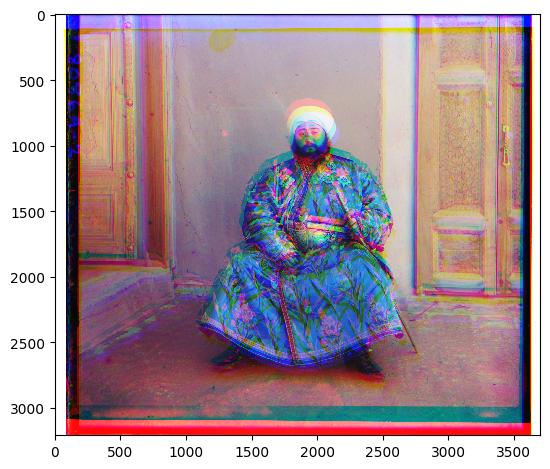

In [29]:
#Let's try simply stacking the channels on top of each other. skio.imshow expects RBG
color_img_nonaligned = np.stack([r, g, b], axis=-1)
skio.imshow(color_img_nonaligned)
skio.show()

###

### Single-scale Implementation

*   Want to use internal pixels not the boarders
*   Exhaustively search over a window of possible displacements (eg: [-15,15] pixels)



In [30]:
def shift_image(img, dy, dx):
    """Shift image by (dy, dx) with zero padding and keep same size."""
    h, w = img.shape
    shifted = np.zeros_like(img)

    # if move up = negative = change the top so start w/ dy g[dy:] here dy is positive
    # if move down = positive = change the bottom g[:h-dy] here the dy is positive

    # Source coordinates in the original image
    y1_src = max(0, -dy)
    y2_src = min(h, h - dy)
    x1_src = max(0, -dx)
    x2_src = min(w, w - dx)

    # Destination coordinates in the shifted image
    y1_dst = max(0, dy)
    y2_dst = min(h, h + dy)
    x1_dst = max(0, dx)
    x2_dst = min(w, w + dx)

    # Copy the overlapping region
    shifted[y1_dst:y2_dst, x1_dst:x2_dst] = img[y1_src:y2_src, x1_src:x2_src]

    return shifted

In [31]:
# Image comparison metrics

def euclidean_dist(img1, img2):
  """The L2 Norm between two images"""
  return np.sqrt(np.sum(np.square(img1-img2)))

def ncc(img1, img2):
  """Normalized Cross-Correlation"""
  img1_norm = img1 / np.linalg.norm(img1)
  img2_norm = img2 / np.linalg.norm(img2)
  return np.sum(img1_norm * img2_norm)

In [32]:
def single_scale(b, g, r):
  """Exhaustively searches over a window of possible displacements.

  Want to add the displacements in a vectorized way.

  Fix b and align g and r to it.
  """
  best_ncc_g, best_disp_g, best_g_img = float("-inf"), None, None
  best_ncc_r, best_disp_r, best_r_img = float("-inf"), None, None

  for h in range(-15,16):
    for w in range(-15,16):
      # Try different alignments for g
      shifted_g = shift_image(g, h, w)
      shifted_r = shift_image(r, h, w)

      # Compute the image metrics only for inner pixels.
      h_b, w_b = b.shape
      h_cut = int(h_b*0.1)
      w_cut = int(w_b*0.1)
      inner_b = b[h_cut:h_b-h_cut, w_cut:w_b-w_cut]
      inner_g = shifted_g[h_cut:h_b-h_cut, w_cut:w_b-w_cut]
      inner_r = shifted_r[h_cut:h_b-h_cut, w_cut:w_b-w_cut]

      # error_g = euclidean_dist(b,shifted_g)
      # error_r = euclidean_dist(b,shifted_r)
      ncc_g = ncc(inner_b, inner_g)
      ncc_r = ncc(inner_b, inner_r)

      # Update the error and displacement
      if ncc_g > best_ncc_g:
        best_ncc_g, best_disp_g, best_g_img = ncc_g, (h, w), shifted_g
      if ncc_r > best_ncc_r:
        best_ncc_r, best_disp_r, best_r_img = ncc_r, (h, w), shifted_r

  return best_ncc_g, best_disp_g, best_ncc_r, best_disp_r, best_g_img, best_r_img


def align(b, g, r):
  return np.stack([r, g, b], axis=-1)

In [34]:
end - start

490.9137132167816

/tmp/ipython-input-592133852.py:8: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(aligned_pic)
/tmp/ipython-input-592133852.py:9: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.show()


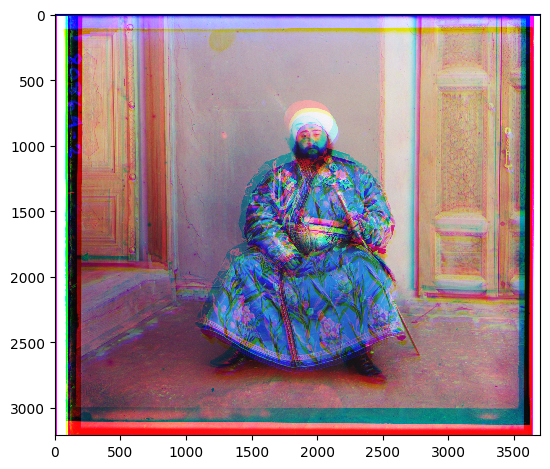

0.946898799006361 (15, 15) 0.8986518018415569 (15, -5)


In [33]:
import time

start = time.time()  # record start time
best_ncc_g, best_disp_g, best_ncc_r, best_disp_r, best_g_img, best_r_img = single_scale(b, g, r)
aligned_pic = align(b, best_g_img, best_r_img)
end = time.time()    # record end time

skio.imshow(aligned_pic)
skio.show()
print(best_ncc_g, best_disp_g, best_ncc_r, best_disp_r)

### High Resolution - Coarse-to-fine Image Pyramid

1. Build the Gaussian Pyramid